In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  
!mkdir -p ~/.kaggle                                          
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log 
!chmod 600 ~/.kaggle/kaggle.json                            
!kaggle config set -n competition -v novozymes-enzyme-stability-prediction   
!kaggle competitions download -c novozymes-enzyme-stability-prediction         
!unzip -o *.zip >> log                                

- competition is now set to: novozymes-enzyme-stability-prediction
  0% 0.00/7.06M [00:00<?, ?B/s]
100% 7.06M/7.06M [00:00<00:00, 125MB/s]


In [3]:
import pandas as pd

df_train = pd.read_csv("train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("train_updates_20220929.csv", index_col="seq_id")

all_features_nan = df_train_updates.isnull().all("columns")

drop_indices = df_train_updates[all_features_nan].index
df_train = df_train.drop(index=drop_indices)

swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

In [4]:
import json

with open('/content/gdrive/MyDrive/Kaggle/thermomutdb.json', 'r') as file:
  json_data = json.loads(file.read())

json_data[0]

{'DOI': '10.1093/oxfordjournals.jbchem.a132423',
 'weight': 28726.09,
 'blosum62': -1,
 'measure': 'CD',
 'pos': 0,
 'pdbs_template': None,
 'year': 1979,
 'protein': 'Tryptophan synthase alpha chain',
 'PDBs_template': None,
 'id': 1,
 'aro': 0,
 'PDB_wild': '1WQ5',
 'reference': 'J BIOCHEM 4, 915-21 (1979)',
 'ca_depth': 4.14,
 'mut_count': 0,
 'neg': -2,
 'pdb_mutant': None,
 'sul': 1,
 'relative_bfactor': 3.47,
 'mutation_type': 'Single',
 'source': 'Escherichia coli (strain K12)',
 'mutation_code': 'E49M',
 'swissprot': 'TRPA_ECOLI (P0A877)',
 'mutation_based': 'PDB and Uniprot',
 'ph': 7.0,
 'neu': -1,
 'ddg': 4.6,
 'method': 'GdnHCl',
 'phi': -118.5,
 'psi': 113.0,
 'sst': 'Strand',
 'rsa': 0.0,
 'effect': 'stabilizing',
 'mutated_chain': 'A',
 'res_depth': 3.53,
 'temperature': 298.95,
 'acc': -2,
 'don': 0,
 'dtm': None,
 'pam250': 0,
 'length': 268.0,
 'uniprot': 'P0A878',
 'PMID': '378988',
 'PIR_ID': 'TSECA'}

In [5]:
import requests

def get_sequence(uniprot_id):
  url = 'https://rest.uniprot.org/uniprotkb/stream?compressed=false&format=json&query=' + uniprot_id
  uniprot_api_response = json.loads(requests.get(url).text)
  
  if 'results' not in uniprot_api_response:
    print(uniprot_api_response)
    return None
  
  if len(uniprot_api_response['results']) == 0:
    print(uniprot_api_response)
    return None

  return uniprot_api_response['results'][0]['sequence']['value']

get_sequence('P0A878')

'MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGADALELGIPFSDPLADGPTIQNATLRAFAAGVTPAQCFEMLALIRQKHPTIPIGLLMYANLVFNKGIDEFYAQCEKVGVDSVLVADVPVEESAPFRQAALRHNVAPIFICPPNADDDLLRQIASYGRGYTYLLSRAGVTGAENRAALPLNHLVAKLKEYNAAPPLQGFGISAPDQVKAAIDAGAAGAISGSAIVKIIEQHINEPEKMLAALKVFVQPMKAATRS'

In [6]:
i, total_elements = 0, len(json_data)
dataframe_lines = []
sequence_cache = {}

for json_element in json_data:

  if i % 10 == 0:
    print('%i of %i' % (i, total_elements))

  i += 1
  
  delta_tm = json_element['dtm']
  delta_dg = json_element['ddg']
  
  if delta_tm is None: continue
  if delta_dg is None: continue

  pdb_id = json_element['PDB_wild']
  uniprot_id = json_element['uniprot']
  mutations = json_element['mutation_code']

  if uniprot_id in sequence_cache:
    sequence = sequence_cache[uniprot_id]
  else:
    sequence = get_sequence(uniprot_id)
    sequence_cache[uniprot_id] = sequence

  line = [pdb_id, uniprot_id, sequence, mutations, delta_tm, delta_dg]
  dataframe_lines.append(line)


0 of 13337
10 of 13337
20 of 13337
30 of 13337
40 of 13337
50 of 13337
60 of 13337
70 of 13337
80 of 13337
90 of 13337
100 of 13337
110 of 13337
120 of 13337
130 of 13337
140 of 13337
150 of 13337
160 of 13337
170 of 13337
180 of 13337
190 of 13337
200 of 13337
210 of 13337
220 of 13337
230 of 13337
240 of 13337
250 of 13337
260 of 13337
270 of 13337
280 of 13337
290 of 13337
300 of 13337
310 of 13337
320 of 13337
330 of 13337
340 of 13337
350 of 13337
360 of 13337
370 of 13337
380 of 13337
390 of 13337
400 of 13337
410 of 13337
420 of 13337
430 of 13337
440 of 13337
450 of 13337
460 of 13337
470 of 13337
480 of 13337
490 of 13337
500 of 13337
510 of 13337
520 of 13337
530 of 13337
540 of 13337
550 of 13337
560 of 13337
570 of 13337
580 of 13337
590 of 13337
600 of 13337
610 of 13337
620 of 13337
630 of 13337
640 of 13337
650 of 13337
660 of 13337
670 of 13337
680 of 13337
690 of 13337
700 of 13337
710 of 13337
720 of 13337
730 of 13337
740 of 13337
750 of 13337
760 of 13337
770 of 133

In [7]:
import pandas as pd

df1 = pd.DataFrame(dataframe_lines, columns=['pdb_id', 'uniprot_id', 'wt_sequence', 'mutations', 'delta_tm', 'delta_dg'])
df1 = df1.drop(columns=["uniprot_id"])
df1

,pdb_id,wt_sequence,mutations,delta_tm,delta_dg
0,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,-6.3,-1.71
1,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.2,-1.77
2,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.6,-1.82
3,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,E128A,0.6,0.16
4,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,V131A,1.0,0.27
...,...,...,...,...,...
3177,1ARR,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,R40A,-26.7,-4.60
3178,1ARR,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,V25A,0.3,-0.40
3179,1ARR,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,V18A,-2.1,-0.50
3180,1ARR,MKGMSKMPQFNLRWPREVLDLVRKVAEENGRSVNSEIYQRVMESFK...,V33A,-13.8,-2.10


In [8]:
import requests
from io import StringIO

def get_fireprot_data():
  url = 'https://raw.githubusercontent.com/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/main/FireprotDB.csv'
  github_response = requests.get(url).text
  
  raw_df = pd.read_csv(StringIO(github_response))
  raw_df = raw_df[['pdb_id','position', 'wild_type', 'mutation', 'sequence', 'dTm', 'ddG']]
  mutations = raw_df.apply(lambda row: row['wild_type'] + str(row['position']) + row['mutation'], axis=1)
  raw_df.insert(0, 'mutations', mutations)
  raw_df = raw_df.drop(columns=["position", "wild_type", "mutation"])
  raw_df = raw_df.rename(columns={ 'sequence': 'wt_sequence', 'dTm': 'delta_tm', 'ddG': 'delta_dg' })
  raw_df = raw_df.dropna(subset=["delta_tm", "delta_dg"])

  return raw_df

df2 = get_fireprot_data()
df2

,mutations,pdb_id,wt_sequence,delta_tm,delta_dg
694,V40A,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-8.5,1.09
695,V75H,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-11.1,2.22
696,V75I,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-12.5,1.42
697,V88I,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-7.4,0.18
698,I115A,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-5.6,1.00
699,W133F,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-5.4,0.00
700,I155A,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-13.2,1.98
701,I155T,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-8.3,0.72
702,I155L,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-5.9,1.56
703,A145T,1RX4,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,-0.4,0.27


In [9]:
df = pd.concat([df1,df2])

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

X = df.delta_dg.values
y = df.delta_tm.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33)

#sx = StandardScaler()
#X_train_scaled = sx.fit_transform(X_train.reshape(-1, 1))

#sy = MinMaxScaler()
#y_train_scaled = np.log1p(sy.fit_transform(y_train.reshape(-1, 1)))

m = Ridge()
#m.fit(X_train_scaled.reshape(-1, 1), y_train_scaled)
m.fit(X_train.reshape(-1, 1), y_train)

y_pred = m.predict(X_test.reshape(-1, 1))
#y_pred = sy.inverse_transform(np.expm1(
#    m.predict(sx.transform(X_test.reshape(-1, 1)))).reshape(-1,1))

print(mean_squared_error(y_pred,y_test))

43.339419096129426


1.7915501181462077


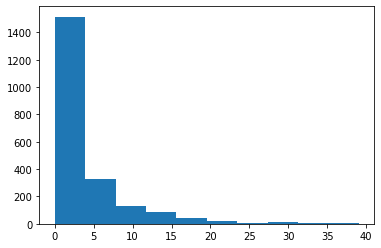

In [11]:
import numpy as np
import matplotlib.pyplot as plt

errs = np.abs(y_pred-y_test)
print(np.median(errs))

plt.hist(errs)
plt.show()

In [12]:
import pandas as pd

df_delta_dg = pd.read_csv('https://raw.githubusercontent.com/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/main/MutationsDeltaDG.csv')
df_delta_dg

,Unnamed: 0,mutated_sequence,pdb_id,wt_sequence,mutations,delta_dg
0,0,MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGAD...,1WQ5,MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGAD...,E49M,4.60
1,1,MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGAD...,1WQ5,MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGAD...,E49Q,-2.50
2,2,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,-1.71
3,3,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-1.77
4,4,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-1.82
...,...,...,...,...,...,...
13689,5650,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M104K,-0.60
13690,5651,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134A,2.20
13691,5652,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134G,7.00
13692,5653,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134I,2.10


In [19]:
df_delta_dg_with_predicted_tm = df_delta_dg.copy()
df_delta_dg_with_predicted_tm.insert(0,"delta_tm",m.predict(df_delta_dg.delta_dg.values.reshape(-1,1)))
df_delta_dg_with_predicted_tm=df_delta_dg_with_predicted_tm.drop(columns=["delta_dg", "Unnamed: 0"])
df_delta_dg_with_predicted_tm

,delta_tm,mutated_sequence,pdb_id,wt_sequence,mutations
0,10.037311,MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGAD...,1WQ5,MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGAD...,E49M
1,-7.273389,MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGAD...,1WQ5,MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGAD...,E49Q
2,-5.347269,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y
3,-5.493556,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y"
4,-5.615463,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y"
...,...,...,...,...,...
13689,-2.640948,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M104K
13690,4.185807,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134A
13691,15.888815,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134G
13692,3.941994,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134I


In [20]:
ToCSV = lambda df_tmp, fname: df_tmp.round(5).to_csv(f'{fname}.csv')
ToCSV(df_delta_dg_with_predicted_tm, '/content/gdrive/MyDrive/Kaggle/MutationsDeltaDGPredictedTm')

In [14]:
df_delta_tm = pd.read_csv('https://raw.githubusercontent.com/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/main/MutationsDeltaTM.csv')
df_delta_tm

,Unnamed: 0,mutated_sequence,pdb_id,wt_sequence,mutations,delta_tm
0,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,-6.3
1,1,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.2
2,2,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.6
3,3,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,E128A,0.6
4,4,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,V131A,1.0
...,...,...,...,...,...,...
4406,759,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,G186S,2.4
4407,760,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,Y192N,3.0
4408,761,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,3D2A,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,N205T,1.4
4409,1126,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,-6.3


In [15]:
df_concat = pd.concat(([df_delta_tm, df_delta_dg_with_predicted_tm]))
df_concat

,Unnamed: 0,mutated_sequence,pdb_id,wt_sequence,mutations,delta_tm
0,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,-6.300000
1,1,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.200000
2,2,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.600000
3,3,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,E128A,0.600000
4,4,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,V131A,1.000000
...,...,...,...,...,...,...
13689,5650,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M104K,-2.640948
13690,5651,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134A,4.185807
13691,5652,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134G,15.888815
13692,5653,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134I,3.941994


In [16]:
df_concat.drop_duplicates(subset=['mutated_sequence'])
df_concat

,Unnamed: 0,mutated_sequence,pdb_id,wt_sequence,mutations,delta_tm
0,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,W138Y,-6.300000
1,1,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.200000
2,2,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"W138Y,W126Y,W158Y",-6.600000
3,3,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,E128A,0.600000
4,4,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2LZM,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,V131A,1.000000
...,...,...,...,...,...,...
13689,5650,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M104K,-2.640948
13690,5651,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134A,4.185807
13691,5652,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134G,15.888815
13692,5653,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3SSI,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,M134I,3.941994


In [17]:
ToCSV = lambda df_tmp, fname: df_tmp.round(5).to_csv(f'{fname}.csv', index_label='seq_id')
ToCSV(df_concat, '/content/gdrive/MyDrive/Kaggle/MutationsDeltaDGandTM')